In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, cross_val_predict

In [2]:
# Задание 1 (+6).
path = 'smsspamcollection/SMSSpamCollection'
messages = pd.read_csv(path, sep='\t',
                           names=["label", "message"])
print(messages.head())
print(messages.groupby('label').describe())
''' Датасет не сбалансирован: 747 спам-сообщений и 4825 смс. За счет такого дисбаланса в выборке, Dummy classifier, который будет
присваивать всем новым сообщениям класс ham, будет иметь хороший accuracy_score=4825/(747+4825)=0.866, однако совсем не будет
справляться с задачей фильтрации спама.'''

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
                                                        message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4


' Датасет не сбалансирован: 747 спам-сообщений и 4825 смс. За счет такого дисбаланса в выборке, Dummy classifier, который будет\nприсваивать всем новым сообщениям класс ham, будет иметь хороший accuracy_score=4825/(747+4825)=0.866, однако совсем не будет\nсправляться с задачей фильтрации спама.'

In [3]:
dummy_clf = ['ham' for i in range(len(messages))]
print('Accuracy score of dummy clf would be', '{0:.3f}'.format(accuracy_score(dummy_clf, messages.label)))

Accuracy score of dummy clf would be 0.866


In [4]:
# 1. Разная токенизация
def tokenize(text): # Знаки пунктуации -- отдельные токены
    return word_tokenize(text) # Функция по дефолту приводит все к нижнему регистру

In [5]:
# Для того, чтобы дальше делать что-нибудь с выборкой, сбалансируем ее -- возьмем ham-сообщений столько же, сколько у нас спама
ham = messages.loc[messages['label'] == 'ham'][:747]
spam = messages.loc[messages['label'] == 'spam']
ham = ham.append(spam) # Добавляю все в один датафрейм
ham = ham.reindex(np.random.permutation(ham.index)) # Перемешиваю
print(ham.head())
ham.to_csv('./ham_spam_balanced.csv', index=False) # Записываю в csv без индексов

     label                                            message
569    ham  Love it! Daddy will make you scream with pleas...
395    ham  Pick you up bout 7.30ish? What time are  and t...
652    ham  I'm gonna say no. Sorry. I would but as normal...
210    ham            Both :) i shoot big loads so get ready!
4725  spam  FREE GAME. Get Rayman Golf 4 FREE from the O2 ...


In [6]:
# Новый сбалансированный перемешанный датасет
df = pd.read_csv('./ham_spam_balanced.csv')
print(df.head())

  label                                            message
0   ham  Love it! Daddy will make you scream with pleas...
1   ham  Pick you up bout 7.30ish? What time are  and t...
2   ham  I'm gonna say no. Sorry. I would but as normal...
3   ham            Both :) i shoot big loads so get ready!
4  spam  FREE GAME. Get Rayman Golf 4 FREE from the O2 ...


In [7]:
# 1.1. Обучаю модель, знаки пунктуации - отдельные токены
bow_11 = CountVectorizer(tokenizer=tokenize) 
bowed_messages = bow_11.fit_transform(df['message'])  
# Буду использовать кросс-валилацию
naive_model = MultinomialNB() 
naive_model.fit(bowed_messages, df['label']) 
nm_predicted = cross_val_predict(naive_model, bowed_messages, df['label'], cv=10) 
print(classification_report(df['label'], nm_predicted)) # В целом, получилось не так плохо
# Нужно посмотреть на confusion matrix, чтобы понять, как обстоят дела с TP и FP
matrix = confusion_matrix(df['label'], nm_predicted)
print(matrix) # 18 не-спам сообщений классификатор отнес к спаму, 44 спам-сообщения не распознались
# Можно еще нарисовать нормализованную матрицу, чтобы было нагляднее (хотя и так понятно)

             precision    recall  f1-score   support

        ham       0.94      0.98      0.96       747
       spam       0.98      0.94      0.96       747

avg / total       0.96      0.96      0.96      1494

[[729  18]
 [ 44 703]]


In [8]:
# Функция отсюда: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.97590361  0.02409639]
 [ 0.05890228  0.94109772]]


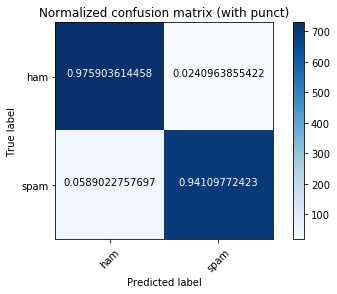

In [9]:
plt.figure()
plot_confusion_matrix(matrix, classes=naive_model.classes_, normalize=True, title='Normalized confusion matrix (with punct)')
plt.show()

In [10]:
# 1.2. Долой знаки препинания!
def tokenize_no_punct(text):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(text)

             precision    recall  f1-score   support

        ham       0.96      0.99      0.97       747
       spam       0.98      0.96      0.97       747

avg / total       0.97      0.97      0.97      1494

[[736  11]
 [ 33 714]]
Normalized confusion matrix
[[ 0.98527443  0.01472557]
 [ 0.04417671  0.95582329]]


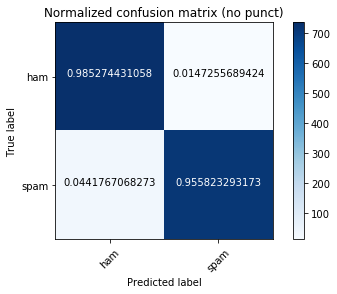

In [11]:
bow_12 = CountVectorizer(tokenizer=tokenize_no_punct) 
bowed_messages = bow_12.fit_transform(df['message'])  
naive_model = MultinomialNB() 
naive_model.fit(bowed_messages, df['label']) 
nm_predicted = cross_val_predict(naive_model, bowed_messages, df['label'], cv=10) 
print(classification_report(df['label'], nm_predicted))
matrix = confusion_matrix(df['label'], nm_predicted)
print(matrix) # 11 не-спам сообщений оказались в спаме (стало лучше) и 33 спам-сообщения не распознались (стало лучше)
plt.figure()
plot_confusion_matrix(matrix, classes=naive_model.classes_, normalize=True, title='Normalized confusion matrix (no punct)')
plt.show()

In [12]:
'''Получилось так:
TP (with punct) < TP (no punct) с пунктуацией не-спама, помеченного как не спам, было меньше - это плохо
FP (with punct) > FP (no punct) с пунктуацией спама, помеченного как не-спам, было больше - это плохо
FN (with punct) > FN (no punct) с пунктуацией не-спама, помеченного как спам, было больше - это плохо
TN (with punct) < TN (no punct) с пунктуацией спама, помеченного как спам, было меньше - это плохо
Вывод: без пунктуации лучше!'''

'Получилось так:\nTP (with punct) < TP (no punct) с пунктуацией не-спама, помеченного как не спам, было меньше - это плохо\nFP (with punct) > FP (no punct) с пунктуацией спама, помеченного как не-спам, было больше - это плохо\nFN (with punct) > FN (no punct) с пунктуацией не-спама, помеченного как спам, было больше - это плохо\nTN (with punct) < TN (no punct) с пунктуацией спама, помеченного как спам, было меньше - это плохо\nВывод: без пунктуации лучше!'

In [13]:
# 2. Разная лемматизация
# 2.1. Без лемматизации - предыдущий пункт
# 2.2. Стэмминг
from nltk.stem.porter import PorterStemmer
def stemmer(text):
    stemmer = PorterStemmer()
    words =  tokenize_no_punct(text)
    return [stemmer.stem(word) for word in words]

bow_22 = CountVectorizer(tokenizer=stemmer) 
bowed_messages = bow_22.fit_transform(df['message'])  
naive_model = MultinomialNB() 
naive_model.fit(bowed_messages, df['label']) 
nm_predicted = cross_val_predict(naive_model, bowed_messages, df['label'], cv=10) 
print(classification_report(df['label'], nm_predicted))
matrix = confusion_matrix(df['label'], nm_predicted)
print(matrix) # 12 не-спам сообщений оказались в спаме и 33 спам-сообщения не распозналось как спам

             precision    recall  f1-score   support

        ham       0.96      0.98      0.97       747
       spam       0.98      0.96      0.97       747

avg / total       0.97      0.97      0.97      1494

[[735  12]
 [ 33 714]]


In [14]:
# 2.3. Лемматизация
from nltk.stem import WordNetLemmatizer
def lemmatize(text):
    wnl = WordNetLemmatizer()
    words =  tokenize_no_punct(text)
    return [wnl.lemmatize(word) for word in words]

bow_23 = CountVectorizer(tokenizer=lemmatize) 
bowed_messages = bow_23.fit_transform(df['message'])  
naive_model = MultinomialNB() 
naive_model.fit(bowed_messages, df['label']) 
nm_predicted = cross_val_predict(naive_model, bowed_messages, df['label'], cv=10) 
print(classification_report(df['label'], nm_predicted))
matrix = confusion_matrix(df['label'], nm_predicted)
print(matrix) # 13 не-спам сообщений оказались в спаме и 37 спам-сообщений не распозналось как спам
# Вывод: токенизатор (без пунктуации) лучше, чем стэммер, а стэммер лучше, чем лемматизатор

             precision    recall  f1-score   support

        ham       0.95      0.98      0.97       747
       spam       0.98      0.95      0.97       747

avg / total       0.97      0.97      0.97      1494

[[734  13]
 [ 37 710]]


In [15]:
# 3. Стоп-слова и df
# 3.1. Удалю стоп-слова, используя токенизатор, который не считает пунктуацию за токены, т.к. он показал лучший результат
bow_31 = CountVectorizer(tokenizer=tokenize_no_punct, stop_words='english') 
bowed_messages = bow_31.fit_transform(df['message'])  
naive_model = MultinomialNB() 
naive_model.fit(bowed_messages, df['label']) 
nm_predicted = cross_val_predict(naive_model, bowed_messages, df['label'], cv=10) 
print(classification_report(df['label'], nm_predicted))
matrix = confusion_matrix(df['label'], nm_predicted)
print(matrix) # 27 не-спам сообщений оказались в спаме и 32 спам-сообщения не распознались. Было: 11 и 33 соответственно.
# Стало хуже, потому что получить на одно спам-сообщение меньше куда хуже, чем получить на 16 меньше важных сообщений.

             precision    recall  f1-score   support

        ham       0.96      0.96      0.96       747
       spam       0.96      0.96      0.96       747

avg / total       0.96      0.96      0.96      1494

[[720  27]
 [ 32 715]]


In [16]:
# 3.2. Пороги минимальной и максимальной df
bow_31 = CountVectorizer(tokenizer=tokenize_no_punct, min_df=0.1, max_df=0.9) 
bowed_messages = bow_31.fit_transform(df['message'])  
naive_model = MultinomialNB() 
naive_model.fit(bowed_messages, df['label']) 
nm_predicted = cross_val_predict(naive_model, bowed_messages, df['label'], cv=10) 
print(classification_report(df['label'], nm_predicted))
matrix = confusion_matrix(df['label'], nm_predicted)
print(matrix) # С заданными порогами результаты получились значимо хуже
# Вывод: по-прежнему с задачей фильтрации спама лучше всего справляется простой токенизатор (без пунктуации)

             precision    recall  f1-score   support

        ham       0.86      0.81      0.84       747
       spam       0.82      0.87      0.85       747

avg / total       0.84      0.84      0.84      1494

[[607 140]
 [ 95 652]]


In [17]:
# 4. Разная векторизация документов
# 4.1. CountVectorizer c токенизатором без пунктуации, см. выше
# 4.2. TfIdfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
bow_42 = TfidfVectorizer(tokenizer=tokenize_no_punct) 
bowed_messages = bow_42.fit_transform(df['message'])  
naive_model = MultinomialNB() 
naive_model.fit(bowed_messages, df['label']) 
nm_predicted = cross_val_predict(naive_model, bowed_messages, df['label'], cv=10) 
print(classification_report(df['label'], nm_predicted))
matrix = confusion_matrix(df['label'], nm_predicted)
print(matrix) # 14 не-спам сообщений оказались в спаме и 35 спам-сообщений не распознались. С CountVectorizer было 11 и 33.
# Вывод: CountVectorizer лучше.

             precision    recall  f1-score   support

        ham       0.95      0.98      0.97       747
       spam       0.98      0.95      0.97       747

avg / total       0.97      0.97      0.97      1494

[[733  14]
 [ 35 712]]


In [18]:
# 5. Что-нибудь еще: не будем приводить слова к нижнему регистру
bow_5 = CountVectorizer(tokenizer=tokenize_no_punct, lowercase=False) 
bowed_messages = bow_5.fit_transform(df['message'])  
naive_model = MultinomialNB() 
naive_model.fit(bowed_messages, df['label']) 
nm_predicted = cross_val_predict(naive_model, bowed_messages, df['label'], cv=10) 
print(classification_report(df['label'], nm_predicted))
matrix = confusion_matrix(df['label'], nm_predicted)
print(matrix) # 13 не-спам сообщений оказались в спаме и 36 спам-сообщений не распознались. Стало немного хуже, эх

             precision    recall  f1-score   support

        ham       0.95      0.98      0.97       747
       spam       0.98      0.95      0.97       747

avg / total       0.97      0.97      0.97      1494

[[734  13]
 [ 36 711]]


In [19]:
# Задание 2 (+2).
# Функция для learning curve отсюда: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

             precision    recall  f1-score   support

        ham       0.96      0.99      0.97       747
       spam       0.98      0.96      0.97       747

avg / total       0.97      0.97      0.97      1494

[[736  11]
 [ 33 714]]


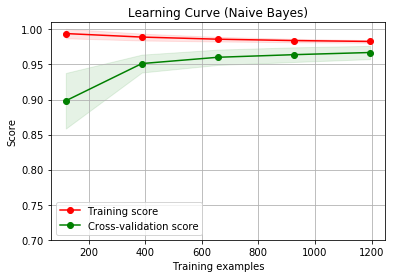

In [21]:
# Байесовский классификатор
##from scikitplot import classifier_factory
from sklearn.metrics import roc_curve
bow = CountVectorizer(tokenizer=tokenize_no_punct) 
bowed_messages = bow.fit_transform(df['message'])  
naive_model = MultinomialNB() 
naive_model.fit(bowed_messages, df['label']) 
nm_predicted = cross_val_predict(naive_model, bowed_messages, df['label'], cv=10) 
print(classification_report(df['label'], nm_predicted)) # classification_report
matrix = confusion_matrix(df['label'], nm_predicted) # confusion_matrix
print(matrix) 
X, y = bowed_messages, df['label']
title = "Learning Curve (Naive Bayes)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(naive_model, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4) # learning curve
# В общем, в idle следующий кусок кода у меня работает, и ROC curve строится, но на анаконду поставить scikitplot мне не удалось
##classifier_factory(naive_model)
##naive_model.plot_roc_curve(bowed_messages, df['label'], random_state=1) # ROC curve
# Поэтому я просто загрузила графики c ROC curve отдельно в репозиторий :(
plt.show()

             precision    recall  f1-score   support

        ham       0.91      0.93      0.92       747
       spam       0.93      0.91      0.92       747

avg / total       0.92      0.92      0.92      1494

[[695  52]
 [ 67 680]]


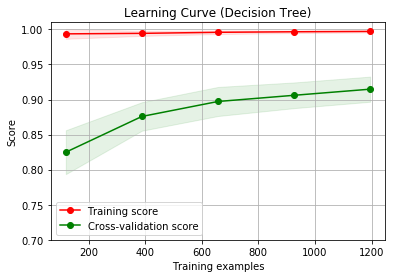

In [26]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(min_samples_split=5) 
dtree.fit(bowed_messages, df['label']) 
dtree_predicted = cross_val_predict(dtree, bowed_messages, df['label'], cv=10) 
print(classification_report(df['label'], dtree_predicted)) # classification_report
matrix = confusion_matrix(df['label'], dtree_predicted) # confusion_matrix
print(matrix) 
title = "Learning Curve (Decision Tree)"
plot_learning_curve(dtree, title, bowed_messages, df['label'], ylim=(0.7, 1.01), cv=cv, n_jobs=4)
##classifier_factory(dtree)
##dtree.plot_roc_curve(bowed_messages, df['label'], random_state=1)
plt.show()

             precision    recall  f1-score   support

        ham       0.93      1.00      0.96       747
       spam       1.00      0.92      0.96       747

avg / total       0.96      0.96      0.96      1494

[[745   2]
 [ 58 689]]


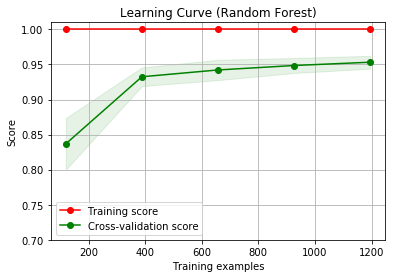

In [29]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 100) 
rf_model.fit(bowed_messages, df['label']) 
rf_predicted = cross_val_predict(rf_model, bowed_messages, df['label'], cv=10) 
print(classification_report(df['label'], rf_predicted)) # classification_report
matrix = confusion_matrix(df['label'], rf_predicted) # confusion_matrix
print(matrix) 
title = "Learning Curve (Random Forest)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(rf_model, title, bowed_messages, df['label'], ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

In [37]:
# В среднем лучше всех показал себя наивный байесовский классификатор, хуже всех -- дерево решений
# Задание 3 (+2).
df["len"].map(df['message'].str.len()).astype(int)
df['caps'] = df.apply(lambda x: sum(sym.isupper() for sym in x['message']), axis=1)
df['digits'] = df.apply(lambda x: sum(sym.isdigit() for sym in x['message']), axis=1)
df['excl'].map(df['message'].str.count('!'))
df['comma'].map(df['message'].str.count(','))
print(df.head())

  label                                            message  len  caps  digits  \
0   ham  Love it! Daddy will make you scream with pleas...   92     3       0   
1   ham  Pick you up bout 7.30ish? What time are  and t...   56     2       3   
2   ham  I'm gonna say no. Sorry. I would but as normal...  119     6       0   
3   ham            Both :) i shoot big loads so get ready!   39     1       0   
4  spam  FREE GAME. Get Rayman Golf 4 FREE from the O2 ...  153    28       5   

   excl  comma  
0     3      0  
1     0      0  
2     1      0  
3     1      0  
4     0      1  


In [39]:
features = ['len', 'caps', 'digits', 'excl', 'comma']
X, y = df[features], df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Наивный байесовский классификатор
naive_model = MultinomialNB()
naive_model.fit(np.array(X_train), np.array(y_train))
nm_predicted = naive_model.predict(X_test)
print(classification_report(y_test, nm_predicted))
matrix = confusion_matrix(y_test, nm_predicted)
print(matrix) # как-то не очень хорошо получилось

             precision    recall  f1-score   support

        ham       0.91      0.92      0.91       157
       spam       0.91      0.89      0.90       142

avg / total       0.91      0.91      0.91       299

[[145  12]
 [ 15 127]]


In [40]:
rf_model = RandomForestClassifier(n_estimators = 100) 
rf_model.fit(np.array(X_train), np.array(y_train)) 
rf_predicted = rf_model.predict(X_test)
print(classification_report(y_test, rf_predicted)) 
matrix = confusion_matrix(y_test, rf_predicted)
print(matrix) 

             precision    recall  f1-score   support

        ham       0.94      0.97      0.96       157
       spam       0.97      0.93      0.95       142

avg / total       0.95      0.95      0.95       299

[[153   4]
 [ 10 132]]


In [ ]:
# Ну, с Random Forest результаты получше, но это все равно хуже, чем bow и CountVectorizer